# Mushroom Cultivation Analysis
Alessio Carnevale, Manuel Cattoni

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from math import comb
from scipy import stats

In [14]:
x = np.array([2, 8, 15, 25])    # Storage temperatures
n = np.array([30, 25, 20, 30])  # Total mushrooms
y = np.array([2, 4, 5, 20])     # Spoiled mushrooms

In [15]:
def lik(theta):
    alpha, beta = theta
    p = 1 / (1 + np.exp(-(alpha + beta * x)))

    l = np.prod([
        comb(n[i], y[i]) * p[i]**y[i] * (1 - p[i])**(n[i] - y[i])
        for i in range(len(n))
    ])
    return l


def log_lik(theta):
    alpha, beta = theta

    # logistic function
    p = 1 / (1 + np.exp(-(alpha + beta * x)))

    # log-likelihood 
    ll = np.sum(stats.binom.logpmf(y, n, p))
    
    return ll


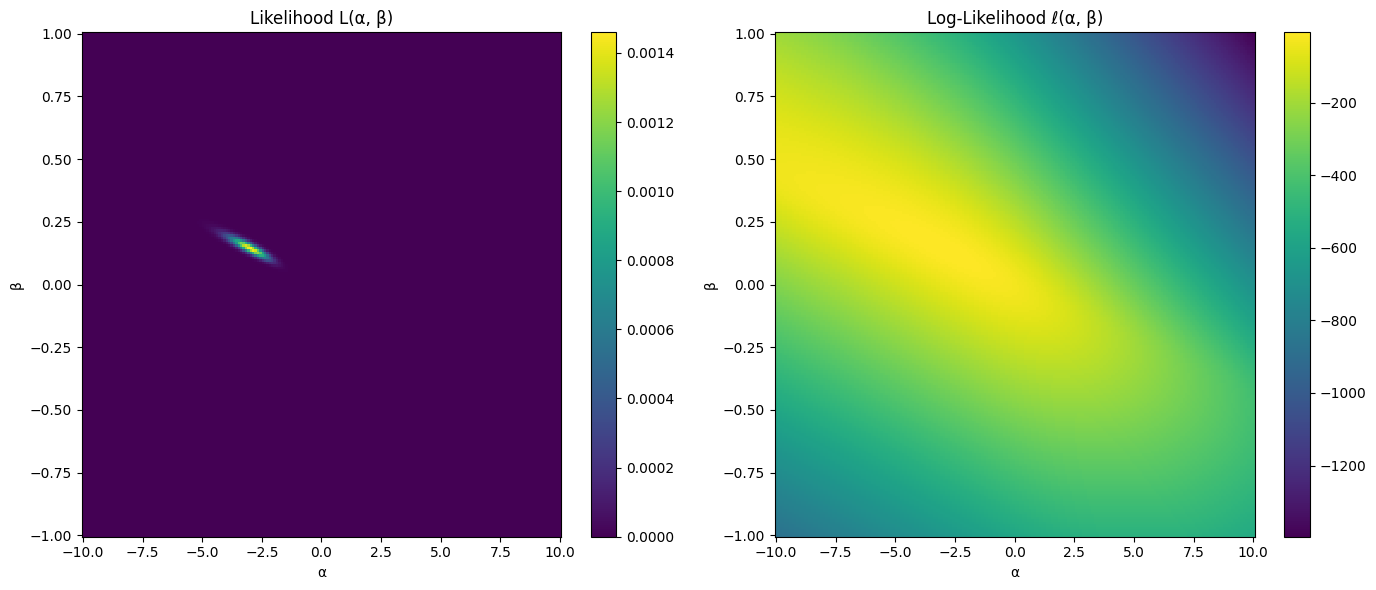

In [16]:
theta = np.array([0.1, 0.05])

# Grid ranges
alpha_vals = np.linspace(-10, 10, 200)
beta_vals = np.linspace(-1, 1, 200)

A, B = np.meshgrid(alpha_vals, beta_vals)

L = np.zeros_like(A)
LL = np.zeros_like(A)

# Compute likelihoods 
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        theta = (A[i, j], B[i, j])
        L[i, j] = lik(theta)
        LL[i, j] = log_lik(theta)

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pc1 = axes[0].pcolormesh(A, B, L, shading='auto')
axes[0].set_title("Likelihood L(α, β)")
axes[0].set_xlabel("α")
axes[0].set_ylabel("β")
fig.colorbar(pc1, ax=axes[0])

pc2 = axes[1].pcolormesh(A, B, LL, shading='auto')
axes[1].set_title("Log-Likelihood ℓ(α, β)")
axes[1].set_xlabel("α")
axes[1].set_ylabel("β")
fig.colorbar(pc2, ax=axes[1])

plt.tight_layout()
plt.show()
